## Introduction

In 1957, the linguist J. R. Firth famously remarked, “You shall know a word by the company it keeps.” This has become a slogan for the area of *distributional semantics*, whereby a word's distribution in the language (i.e. the words that tend to surround it) is taken to be an actionable representation of its meaning. 

A few years later, the pioneers of *informational retrieval* began to use computers to do *vectorial semantics*, which is an approach to NLP that takes distributional semantics to mathematical and computational extremes. Generally in vectorial semantics, words are represented as vectors that characterize the contexts in which they occur in some large corpus of text. Likewise, chunks of such copora called *documents* are also represented as vectors. This type of technology is the center of search engines that accept textual queries and return textual results, such as Google.

Here, we will be experimenting with a few of the models in the areas of distributional and vectorial semantics.




## Corpus Extraction

First, before conducting the experiments on various models, we need to construct our corpus. A useful corpus for our models that I utilized, and may provide some interesting results, are [Wikipedia](https://www.wikipedia.org/) articles. 

We will need a lot; a good amount is somewhere around 1,000 total wikipedia articles. We also need our articles to fall into one of three *distinct* topics; they need to be distinct enough to where one can identify which article belongs to which topic, which will be important when we view the results of our models later. A sufficient amount of articles per topic is around 200-250 articles.

To compile these Wikipedia articles, I used the Python library [wikipedia](https://pypi.org/project/wikipedia/), which greatly facilitated my ability to extract the text from any Wikipedia article whose title is known. Here is a code example that extracts the content of the article for the city of Seattle:

In [ ]:
# first install wikipedia
!pip install wikipedia

In [ ]:
import wikipedia
article_text = wikipedia.page("Seattle").content
print(article_text)

Seattle ( (listen) see-AT-əl) is a seaport city on the West Coast of the United States. It is the seat of King County, Washington. With a 2019 population of 753,675, it is the largest city in both the state of Washington and the Pacific Northwest region of North America. The Seattle metropolitan area's population is 3.98 million, making it the 15th-largest in the United States. Between 2013 and 2016, Seattle was rated the fastest-growing major city and  remained in the top five in May 2015 with an annual growth rate of 2.1%. In July 2016, Seattle ranked as the fastest-growing major U.S. city, with a 3.1% annual growth rate, and continuously among the fastest growing cities in the United States.Seattle is situated on an isthmus between Puget Sound (an inlet of the Pacific Ocean) and Lake Washington. It is the northernmost major city in the United States, located about 100 miles (160 km) south of the Canadian border. A major gateway for trade with northern Asia, Seattle is the fourth-lar

The trickiest, and perhaps most tedious, part of this extraction is finding these list of articles and extracting them efficiently. To find the list of articles, I consulted the Wikipedia article [list of list of lists](https://en.wikipedia.org/wiki/List_of_lists_of_lists); you can expect to dive a few levels deep to find an actual list of articles. From this article, the three lists I chose are the [list of GameCube games](https://en.wikipedia.org/wiki/List_of_GameCube_games), the [list of comedy films from the 2010s](https://en.wikipedia.org/wiki/List_of_comedy_films_of_the_2010s), and the [list of wars from 1990-2002](https://en.wikipedia.org/wiki/List_of_wars:_1990%E2%80%932002).

To extract them more efficiently, I utilized [Scrapy](https://scrapy.org/), a web crawler & scraper built for Python. I won't go into too much depth of how to crawl the webpages here, but there are ample tutorials online to help in getting set up with a basic spider in Scrapy. Once you find a promising list, I recommend viewing the page source with your browser's equivalent of "Inspect Element" by right clicking on an entry on your list of choice and finding the Xpath to all titles of the list from there.

Alternatively, you can download my list of titles that I utlized from the main Github project page.

The hierarchy of folders containing the content of each Wikipedia page must look like this (be sure to name each file as the article's title):

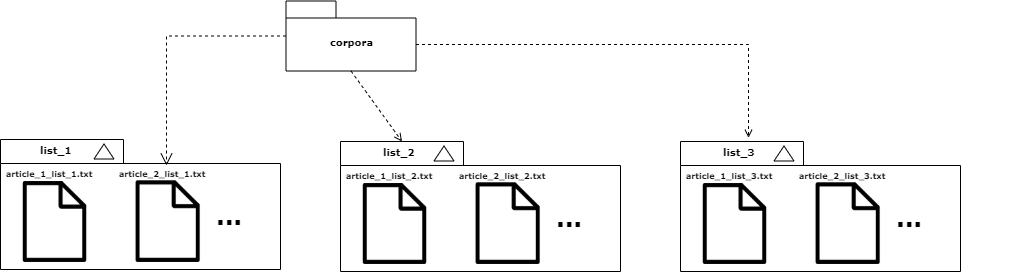

Run the following code block utilizing the wikipedia package on each list of titles, corresponding to each topic, to store the article content of these titles as individual files:

In [ ]:
import wikipedia
import os

def main():
    print("Building corpora for model, this may take a while...")
    os.mkdir("/content/corpus/")
    for lst in os.listdir('/content/'):
      if lst.endswith('.txt'):
        print("Processing titles from list " + lst)
        os.chdir("/content/")
        titles = open(lst, "r")
        os.chdir("/content/corpus/")
        os.mkdir(lst[0:-4] + "/") # make folder for list's content
        os.chdir(lst[0:-4] + "/")
        count = 1
        for row in titles:
          try:
            article_text = wikipedia.page(row).content
            output_file = open("/content/corpus/"+ lst[0:-4] + "/" + row[:-1] + ".txt", "w") # create a txt with article content
            output_file.write(article_text)
            print("Finished writing content from title " + row[:-1] + " of list " + lst + " to a text file")
            count = count+1
          except: #if wikipedia cannot find page, skip it
            continue
        print("Finished all titles from list " + lst + "\n")
        print("Count: " + str(count))
        count = 0
        print("-" * 100)
      else:
        continue

if __name__=="__main__":
    main()

Building corpora for model, this may take a while...
Processing titles from list games.txt
Finished writing content from title 2006 FIFA World Cup (video game) of list games.txt to a text file
Finished writing content from title 4x4 EVO 2 of list games.txt to a text file
Finished writing content from title The Adventures of Jimmy Neutron Boy Genius: Attack of the Twonkies of list games.txt to a text file
Finished writing content from title The Adventures of Jimmy Neutron Boy Genius: Jet Fusion of list games.txt to a text file
Finished writing content from title All-Star Baseball 2002 of list games.txt to a text file
Finished writing content from title All-Star Baseball 2003 of list games.txt to a text file
Finished writing content from title All-Star Baseball 2004 of list games.txt to a text file
Finished writing content from title American Chopper 2: Full Throttle of list games.txt to a text file
Finished writing content from title Animal Crossing (video game) of list games.txt to a t

With our corpora prepared, we are ready process it in order to create our first model.

## Bag of Words (BOW) Model

Perhaps the simplest approach to vectorial semantics. In this method, a corpus is processed to create a *document-term matrix*; this is just a table that records how many times each word in the corpus occured in each document (i.e. each article in our case). In this matrix, each row corresponds to a document, each column corresponds to a term, and each cell contains how many times the term appears in the corresponding document:

|            | this | is | a | test | string |
|------------|------|----|---|------|--------|
| Document 1 | 2    | 1  | 2 | 1    | 1      |
| Document 2 | 2    | 2  | 1 | 0    | 1      |


What is clever about the BOW model is how it treats the rows and columns in this matrix as *vectors*, or an array of numbers. The rows would be considered document vectors, and the columns word vectors. In doing so, we can take the *cosine* between these vectors, producing a real number in the range $[-1,1]$ that captures the similarity of two vectors. 

Because the vectors represent either words or documents, [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) can be treated as a measure of the relatedness of two words or two documents in some sense. In the case of comparing two documents, if the documents describe particular concepts, then the cosine similarity between two documents can be treated as a measure of the relatedness of those concepts.



This type of model belongs to a family of others like it called the *vector space models of semantics (VSMs)*. This is because the matrix contains two *vector spaces*, one containing only documents and the other containing only words. In addition, the vectors can be thought of as coordinates in a high dimensional space - in the above example, the document space is 5 dimensional, but in reality you can have thousands of dimensions, one for every unique token. In this vector space, related documents would be closer in proximity, and less related ones will be farther away; this is also the case in the word vector space.

Alright, with the background info out of the way, we can start constructing this model. First, we will need to tokenize the corpus; I use the [nltk](https://pypi.org/project/nltk/) package to do so. We will need to assign an integer identifier to each unique token and each document title, in the range $[0,$ number of unique tokens$]$ and $[0,$ number of docs$]$ inclusive. We can also save the document titles and unique tokens as [numpy](https://pypi.org/project/numpy/) arrays, so we wouldn't have to repeat this process later (and just utilize these arrays instead).

In [ ]:
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
import os
import string

def main():
  # loop to find all tokens and counts
  unique_tokens = []
  document_titles = []
  for root, dirs, files in os.walk("/content/corpus"):
    for current_dir in dirs:
      path1 = os.path.join(root, current_dir)
      for root2, dirs2, files2 in os.walk(path1):
        for current_file in files2:
          print("Find all unique tokens:", current_file)
          path2 = os.path.join(root2, current_file)
          current_file_text = open(path2, "r").read()
          tokenizer = RegexpTokenizer(r'\w+')
          tokens = tokenizer.tokenize(current_file_text.lower())
          # -4 to remove .txt for title
          document_titles.append(current_file[:-4])
          for token in tokens:
            if token not in unique_tokens:
              unique_tokens.append(token)
  os.chdir("/content/")
  # Save the tokenized tokens and doc_titles as numpy arrays, use latter two commented lines to load them
  np.save("unique_tokens", np.array(unique_tokens))
  np.save("doc_titles", np.array(document_titles))
  # unique_tokens = np.load("unique_tokens.npy")
  # document_titles = np.load("doc_titles.npy")

  # stores token identifiers in token_ids and document identifiers in doc_ids
  identifiers_tokens = {}
  index = 0
  for token in unique_tokens:
    identifiers_tokens[token] = index
    index += 1

  identifiers_docs = {}
  index = 0
  for doc in document_titles:
    identifiers_docs[doc] = index
    index +=1

  # Save identifier_tokens & identifier_docs as numpy arrays for later, or load them
  np.save("identifiers_tokens", np.array(identifiers_tokens))
  np.save("identifiers_docs", np.array(identifiers_docs))
  # identifier_tokens = np.load("identifier_tokens.npy")
  # identifier_docs = np.load("identifier_docs.npy")

if __name__ == '__main__':
    main()

Find all unique tokens: FIFA Football 2002.txt
Find all unique tokens: Korokke! Ban-? no Kiki o Sukue.txt
Find all unique tokens: The Legend of Zelda: Ocarina of Time Master Quest.txt
Find all unique tokens: The Incredibles: Rise of the Underminer.txt
Find all unique tokens: Avatar: The Last Airbender (video game).txt
Find all unique tokens: Hot Wheels Velocity X.txt
Find all unique tokens: Bratz: Forever Diamondz (video game).txt
Find all unique tokens: Egg Mania: Eggstreme Madness.txt
Find all unique tokens: Conan (2004 video game).txt
Find all unique tokens: Frogger Beyond.txt
Find all unique tokens: Disney's Party.txt
Find all unique tokens: Dragon Ball Z: Budokai 2.txt
Find all unique tokens: Disney's Extreme Skate Adventure.txt
Find all unique tokens: Dave Mirra Freestyle BMX 2.txt
Find all unique tokens: Dance Dance Revolution Mario Mix.txt
Find all unique tokens: Billy Hatcher and the Giant Egg.txt
Find all unique tokens: Fire Emblem: Path of Radiance.txt
Find all unique tokens

Now, we need to construct the document-term matrix aforementioned. It is best, again, to represent this as a numpy array. Since you have to know the size of a numpy array before initializing it, count the number of unique tokens and initialize the array as all zeroes. Iterate over each token's occurence in each document, incrementing the count of the cell in the row of the token & column of the document, filling the matrix:

In [ ]:
import numpy as np
import nltk
from scipy import spatial
from nltk.tokenize import RegexpTokenizer
import os

def main():
  token_ids = np.load("identifiers_tokens.npy", allow_pickle=True).item()
  doc_ids = np.load("identifiers_docs.npy", allow_pickle=True).item()
  doc_term_matrix = np.zeros((len(token_ids), len(doc_ids)))

  print("Now populating BOW document-term matrix...")
  for root, dirs, files in os.walk("corpus"):
    for current_dir in dirs:
      path1 = os.path.join(root, current_dir)
      for root2, dirs2, files2 in os.walk(path1):
        for current_file in files2:
          path2 = os.path.join(root2, current_file)
          with open(path2, "r") as currfile:
            current_file_text = currfile.read()
          tokenizer = RegexpTokenizer(r'\w+')
          tokens = tokenizer.tokenize(current_file_text.lower())
          # -4 to remove \n.txt for title
          doc_name = current_file[:-4]
          print("Filling BOW matrix's token counts for document ", doc_name)
          for token in tokens:
            doc_term_matrix[token_ids[token]][doc_ids[doc_name]] += 1

  #Save this BOW matrix, use latter line to load it if you already have it
  np.savez("bow_doc_term_matrix", doc_term_matrix)
  # matrix = np.load("bow_doc_term_matrix")['arr_0']

if __name__ == '__main__':
    main()

Now populating BOW document-term matrix...
Filling BOW matrix's token counts for document  FIFA Football 2002
Filling BOW matrix's token counts for document  Korokke! Ban-? no Kiki o Sukue
Filling BOW matrix's token counts for document  The Legend of Zelda: Ocarina of Time Master Quest
Filling BOW matrix's token counts for document  The Incredibles: Rise of the Underminer
Filling BOW matrix's token counts for document  Avatar: The Last Airbender (video game)
Filling BOW matrix's token counts for document  Hot Wheels Velocity X
Filling BOW matrix's token counts for document  Bratz: Forever Diamondz (video game)
Filling BOW matrix's token counts for document  Egg Mania: Eggstreme Madness
Filling BOW matrix's token counts for document  Conan (2004 video game)
Filling BOW matrix's token counts for document  Frogger Beyond
Filling BOW matrix's token counts for document  Disney's Party
Filling BOW matrix's token counts for document  Dragon Ball Z: Budokai 2
Filling BOW matrix's token counts 

The BOW matrix is now filled! Let's run an experiment to see if this BOW model can distinguish between the three topics of this corpus, using cosine similarity. We can produce a table, with the topics on the rows and columns, containing cells that are the average similarity score for all docs in the row topic relative to all docs in the column topic. We should expect to see the diagonal of this matrix to contain values that are somewhat different than the values of the other cells, since we are comparing documents from the same topics in the row and column.

My document-term matrix consists of games, wars, and comedy movies, so these are the three topics I am comparing in this code block. Since there isn't a way to determine which indices in the document-term matrix belong to which topic, I will have to hard-code in the exact cut-off for each within this matrix, obtained from `identifiers_docs.npy`; you may need to with your topics as well.

In [ ]:
# Install tabulate, prints table in an organized way
!pip install tabulate

In [ ]:
import numpy as np
from tabulate import tabulate
import nltk
from scipy import spatial
import os

def main():
  doc_ids = np.load("identifiers_docs.npy", allow_pickle=True).item()
  
  # Snippet used to find cut-offs:
  # print("Here are the doc ids \n")
  # for k, v in doc_ids.items():
  #   print(k, '-->', v)

  os.chdir("/content")
  doc_term_matrix = np.load("bow_doc_term_matrix.npz")
  doc_term_matrix = doc_term_matrix['arr_0']

  mm_count, movie_movie = 0, 0
  mg_count, movie_game = 0, 0
  mw_count, movie_war = 0, 0
  gg_count, game_game = 0, 0
  gw_count, game_war = 0, 0
  ww_count, war_war = 0, 0

  '''
  For my corpora:

  0-241 are films
  242-495 are games
  496-745 are wars
  '''
  for x in range(len(doc_ids)):
    print("Comparing document number " + str(x))
    for y in range(len(doc_ids)):
      relatedness = 1 - spatial.distance.cosine(doc_term_matrix[x], doc_term_matrix[y])
      if x <= 241 and y <= 241:
        mm_count += 1
        movie_movie += relatedness
      elif x <= 241 and y <= 495:
        mg_count += 1
        movie_game += relatedness
      elif x <= 241 and y <= 745:
        mw_count += 1
        movie_war += relatedness
      elif x <= 495 and y <= 495:
        gg_count += 1
        game_game += relatedness
      elif x <= 495 and y <= 745:
        gw_count += 1
        game_war += relatedness
      elif x <= 745 and y <= 745:
        ww_count += 1
        war_war += relatedness
      else:
        print("Out of Bounds Error, tried to access: \n")
        print("x = " + str(x) + "\n")
        print("y = " + str(y) + "\n")

  movie_movie = movie_movie / (mm_count)
  movie_war = movie_war / (mw_count)
  game_game = game_game / (gg_count)
  game_war = game_war / (gw_count)
  war_war = war_war / (ww_count)
  movie_game = movie_game / (mg_count)

  print("-" * 100)
  print(tabulate([[" ","Movies", "Games", "Wars"],["Movies"," ", movie_movie, movie_game, movie_war],["Games"," ", movie_game, game_game, game_war],["Wars"," ", movie_war, game_war, war_war]],
                  headers="firstrow"))

if __name__=="__main__":
    main()


Comparing document number 0
Comparing document number 1
Comparing document number 2
Comparing document number 3
Comparing document number 4
Comparing document number 5
Comparing document number 6
Comparing document number 7
Comparing document number 8
Comparing document number 9
Comparing document number 10
Comparing document number 11
Comparing document number 12
Comparing document number 13
Comparing document number 14
Comparing document number 15
Comparing document number 16
Comparing document number 17
Comparing document number 18
Comparing document number 19
Comparing document number 20
Comparing document number 21
Comparing document number 22
Comparing document number 23
Comparing document number 24
Comparing document number 25
Comparing document number 26
Comparing document number 27
Comparing document number 28
Comparing document number 29
Comparing document number 30
Comparing document number 31
Comparing document number 32
Comparing document number 33
Comparing document numbe

Not fantastic, but not bad either; the differences in these documents within the model are very small, yet  pretty distinct.

Let's try to create a wrapper for this BOW model allowing us to submit a title from our corpora, and receive a ranked listing of the ten most related articles based on cosine similarity:

In [ ]:
import numpy as np
from scipy import spatial

def get_ten_most_related(wikipedia_title):
  document_titles = np.load("doc_titles.npy")
  docs = np.load("identifiers_docs.npy", allow_pickle=True).item()
  doc_term_matrix = np.load("bow_doc_term_matrix.npz")
  doc_term_matrix = doc_term_matrix['arr_0']

  if wikipedia_title not in docs:
    return print("Invalid article title, please pick one from your corpora w/ proper capitalization & spelling")
  
  document_titles = np.load("doc_titles.npy")
  index = docs[wikipedia_title]
  top_10 = [(0.0,""), (0.0,""), (0.0,""), (0.0,""), (0.0,""), (0.0,""), 
            (0.0,""), (0.0,""), (0.0,""), (0.0,"")]

  for i in range(len(document_titles)):
    relatedness = 1 - spatial.distance.cosine(doc_term_matrix[index], doc_term_matrix[i])
    #skip completely similar article that is just itself
    if relatedness == 1.0:
      continue
    for j in range(len(top_10)):
      if relatedness > top_10[j][0] and (0.0,"") not in top_10:
        title = document_titles[i]
        top_10[j] = (relatedness, title)
        break
      elif top_10[j] == (0.0,""):
        title = document_titles[i]
        top_10[j] = (relatedness, title)
        break

  #sorts list in descending order
  top_10.sort(key=lambda x: x[0], reverse=True)
  return top_10

def main():
  print(get_ten_most_related("Cuban Revolution")) #replace with title from corpora

if __name__ == '__main__':
    main()

[(0.44546584287246327, 'South African Border War'), (0.41673610257249627, 'Austenland (film)'), (0.40567404226968806, 'South Lebanon conflict (1985–2000)'), (0.3541578054994302, 'Mexico–Guatemala conflict'), (0.3420526275297414, 'When a Wolf Falls in Love with a Sheep'), (0.33735211813904953, '1947–48 Civil War in Mandatory Palestine'), (0.3093813410005394, 'Just Call Me Nobody'), (0.2861920375428729, 'You Again'), (0.28114990216913105, 'Battle of the Paracel Islands'), (0.27553868807746573, "Mr. Popper's Penguins (film)")]


There are, of course, a lot of results that aren't directly related to the Cuban Revolution while using my corpora, however among the top 10 are other conflicts that had some Communist element within their articles as did the Cuban Revolution article, such as the [South African Border War](https://en.wikipedia.org/wiki/South_African_Border_War) and the [Mexico-Guatemala Conflict](https://en.wikipedia.org/wiki/Mexico%E2%80%93Guatemala_conflict). The former mentions "Cuba" as a term throughout the article, giving it a higher similarity score.

There is definitely a lot of room for refinement for this specific approach, however there are some more principled approaches towards extracting these types of semantic relationships between documents.

## Term Frequency-Inverse Document Frequency (TF-IDF) Model

The classic improvement over the basic BOW model is the *term frequency-inverse document frequency*, or *tf-idf* model. This refinement over the BOW model uses the fact that terms which occur frequently in a corpus tell you less about the documents in which they occur. Examples of these frequent terms are stop words like *the*, *is*, and *and*; on the other hand, the occurence of a rare word like *mitochondria* likely indicates that the document pertains to biology in some way. The occurence of this rare word also provides more information about the document in which it occurs. From the standpoint of information retrieval, such as a search engine, such rare terms would better serve as keywords in a search query. 

In tf-idf, *term frequency* refers to the number of times that a given term occured in a given document - each count in each cell in the previous document term matrix is a term frequency. Often, the raw term frequency is divided by the number of tokens in the document, as a way to normalize for document length. 

The *inverse document frequency* for a given term is a measure of the proportion of corpus documents that contain the term. It is typically calculated as 
$\log (\frac{N}{D})$,
where $N$ is the number of documents in the corpus and $D$ is the number of documents containing the term. 

By taking the product of the term frequency and the inverse-document frequency for a given term, we can derive a measure of the term's importance in describing the document. For example, if the term *mitochondria* only appears in five documents, but appears in them frequently, it may provide a lot of information about those five documents. 


Therefore, we can try to refine the BOW model to convert it into a tf-idf model by first doing some preprocessing on the corpus itself:
1. First, convert all text to lowercase.
2. Second, remove *stopwords*, i.e. those aformentioned (and, is, the, etc.). While the tf-idf model does penalize terms that appear all over the corpus, a more conventional step is to remove all stopwords beforehand. They are functional words that occur too often and provide little information about the context in which they occur. I added a file called `stopwords.txt` to the Github project main page that can be used for this purpose, but feel free to use whichever suitable list that you wish.
3. Lastly, *lemmatize* all of the words; a word's lemma is its dictionary form. For example, the lemma of *giraffes* is *giraffe*. In vectorial semantics, we generally don't care about a word's inflection, but rather its general meaning. Therefore, rather than treating the word and its lemma as separate terms, we should combine them. NLTK utilizes a lemmatize that is perfect for this task, which I use below.

These three tasks are shown below for my corpus of movies, games, and wars: 

In [ ]:
# first install wikipedia
!pip install wikipedia

In [22]:
import wikipedia
import os
import string
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def main():
    print("Building corpora for model, this may take a while...")
    
    # Get stopwords
    stopwords = open("/content/stopwords.txt", "r")
    list_of_stopwords = []
    for row in stopwords:
      list_of_stopwords.append(row.strip('\n'))
    
    #Open each txt file of titles, write article content to corresponding folder
    lemmatizer = WordNetLemmatizer()
    os.mkdir("/content/corpus/")
    for lst in os.listdir('/content/'):
      if lst.endswith('.txt') and lst != "stopwords.txt":
        print("Processing titles from list " + lst)
        os.chdir("/content/")
        titles = open(lst, "r")
        os.chdir("/content/corpus/")
        os.mkdir(lst[0:-4] + "/") # make folder for list's content
        os.chdir(lst[0:-4] + "/")
        count = 1
        for row in titles:
          try:
            article_text = wikipedia.page(row).content
            article_text = article_text.lower() # convert all text to lowercase
            processed_article_text = ""
            output_file = open("/content/corpus/"+ lst[0:-4] + "/" + row[:-1] + ".txt", "w") # create a file with article content
            tokenizer = RegexpTokenizer(r'\w+')
            tokens = tokenizer.tokenize(article_text)
            for token in tokens: #only write token to file if not stopword + lemmatized 
              if token not in list_of_stopwords:
                lemmatized = lemmatizer.lemmatize(str(token))
                processed_article_text = processed_article_text + lemmatized + " "
            output_file.write(processed_article_text)
            processed_article_text = ""
            print("Finished writing content from title " + row[:-1] + " of list " + lst + " to a text file")
            count = count+1
          except: #if wikipedia cannot find page, skip it
            continue
        print("Finished all titles from list " + lst + "\n")
        print("Count: " + str(count))
        count = 0
        print("-" * 100)
      else:
        continue

if __name__=="__main__":
    main()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Building corpora for model, this may take a while...
Processing titles from list films.txt
Finished writing content from title The Bounty Hunter (2010 film) of list films.txt to a text file
Finished writing content from title Burke and Hare (2010 film) of list films.txt to a text file
Finished writing content from title Casino Jack of list films.txt to a text file
Finished writing content from title Cemetery Junction (film) of list films.txt to a text file
Finished writing content from title The Clink of Ice of list films.txt to a text file
Finished writing content from title Cop Out (2010 film) of list films.txt to a text file
Finished writing content from title Cyrano Agency of list films.txt to a text file
Finished writing content from title Cyrus (2010 film) of list films.txt to a text file
Finished writing content from title Date Night of list films.txt to a text file

/usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Finished writing content from title Service Entrance of list films.txt to a text file
Finished writing content from title The Smurfs (film) of list films.txt to a text file
Finished writing content from title Something Borrowed (film) of list films.txt to a text file
Finished writing content from title Spy Kids: All the Time in the World of list films.txt to a text file
Finished writing content from title Sunny (2011 film) of list films.txt to a text file
Finished writing content from title Take Me Home Tonight (film) of list films.txt to a text file
Finished writing content from title Terri (film) of list films.txt to a text file
Finished writing content from title Tous les soleils of list films.txt to a text file
Finished writing content from title Tower Heist of list films.txt to a text file
Finished writing content from title A Very Harold & Kumar Christmas of list films.txt to a text file
Finished writing content from title Win Win (film) of list films.txt to a text file
Finished 

Next, we need to construct the tf-idf matrix itself on the processed corpus. Again, this will be a matrix with documents on the rows and terms on the columns, and again it will be represented as a `numpy` array. Instead of placing raw term frequencies in the cells, this time you’ll  be  placing  tf–idf  values  in  them.

Given  a  term  and  document,  a  tf–idf  value  can  be derived  in  the  following  manner: 

- The tf  component  is  calculated  as  the  number  of occurrences of that term in that document divided by the number of total term occurrences in the document (i.e., its length after processing). 
- The idf component is the equation aformentioned, calculated as $\log \frac{N}{D}$ where $N$ is the number of documents in the corpus and $D$ is the number of documents containing the term at hand.
- The final tf-idf value is the product of these two values.

Once the tf-idf values have been placed in each cell, a full tf-idf matrix will have been constructed.

First, just as with the BOW model, we will need to tokenize the corpus & assign an integer identifier to each unique token and document:

In [24]:
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
import os
import string

def main():
  # loop to find all tokens and counts
  unique_tokens = []
  document_titles = []
  for root, dirs, files in os.walk("/content/corpus"):
    for current_dir in dirs:
      path1 = os.path.join(root, current_dir)
      for root2, dirs2, files2 in os.walk(path1):
        for current_file in files2:
          print("Find all unique tokens:", current_file)
          path2 = os.path.join(root2, current_file)
          current_file_text = open(path2, "r").read()
          tokenizer = RegexpTokenizer(r'\w+')
          tokens = tokenizer.tokenize(current_file_text.lower())
          # -4 to remove .txt for title
          document_titles.append(current_file[:-4])
          for token in tokens:
            if token not in unique_tokens:
              unique_tokens.append(token)
  os.chdir("/content/")
  # Save the tokenized tokens and doc_titles as numpy arrays, use latter two commented lines to load them
  np.save("unique_tokens", np.array(unique_tokens))
  np.save("doc_titles", np.array(document_titles))
  # unique_tokens = np.load("unique_tokens.npy")
  # document_titles = np.load("doc_titles.npy")

  # stores token identifiers in token_ids and document identifiers in doc_ids
  identifiers_tokens = {}
  index = 0
  for token in unique_tokens:
    identifiers_tokens[token] = index
    index += 1

  identifiers_docs = {}
  index = 0
  for doc in document_titles:
    identifiers_docs[doc] = index
    index +=1

  # Save identifier_tokens & identifier_docs as numpy arrays for later, or load them
  np.save("identifiers_tokens", np.array(identifiers_tokens))
  np.save("identifiers_docs", np.array(identifiers_docs))
  # identifier_tokens = np.load("identifier_tokens.npy")
  # identifier_docs = np.load("identifier_docs.npy")

if __name__ == '__main__':
    main()

Find all unique tokens: The Smurfs (film).txt
Find all unique tokens: Gulliver's Travels (2010 film).txt
Find all unique tokens: When a Wolf Falls in Love with a Sheep.txt
Find all unique tokens: Nanny McPhee and the Big Bang.txt
Find all unique tokens: Dylan Dog: Dead of Night.txt
Find all unique tokens: Nothing to Declare (film).txt
Find all unique tokens: 21 Jump Street (film).txt
Find all unique tokens: The Three Stooges (2012 film).txt
Find all unique tokens: Get Him to the Greek.txt
Find all unique tokens: Flipped (2010 film).txt
Find all unique tokens: Sex and the City 2.txt
Find all unique tokens: Diary of a Wimpy Kid (film).txt
Find all unique tokens: Oki's Movie.txt
Find all unique tokens: Here Comes the Bride (2010 film).txt
Find all unique tokens: Frankenweenie (2012 film).txt
Find all unique tokens: Hospitalité.txt
Find all unique tokens: Valentine's Day (2010 film).txt
Find all unique tokens: God Bless America (film).txt
Find all unique tokens: The Fierce Wife.txt
Find al

Next, we can begin to fill the tf-idf matrix. The BOW term matrix described in the previous section can be useful again to obtain all of the unique term frequencies for each document, to help fulfill the tf component of the tf-idf matrix. Therefore, it is built & filled again here, before proceeding towards creating the tf-idf matrix:

In [27]:
import numpy as np
import nltk
from scipy import spatial
from nltk.tokenize import RegexpTokenizer
import os

def main():
  # Initialize and fill BOW matrix with term frequencies
  token_ids = np.load("identifiers_tokens.npy", allow_pickle=True).item()
  doc_ids = np.load("identifiers_docs.npy", allow_pickle=True).item()
  num_docs = len(doc_ids)
  num_tokens = len(token_ids)
  doc_term_matrix = np.zeros((num_docs, num_tokens))

  print("Now populating BOW document-term matrix...")
  for root, dirs, files in os.walk("corpus"):
    for current_dir in dirs:
      path1 = os.path.join(root, current_dir)
      for root2, dirs2, files2 in os.walk(path1):
        for current_file in files2:
          path2 = os.path.join(root2, current_file)
          with open(path2, "r") as currfile:
            current_file_text = currfile.read()
          tokenizer = RegexpTokenizer(r'\w+')
          tokens = tokenizer.tokenize(current_file_text.lower())
          # -4 to remove \n.txt for title
          doc_name = current_file[:-4]
          print("Filling BOW matrix's token counts for document ", doc_name)
          for token in tokens:
            doc_term_matrix[doc_ids[doc_name]][token_ids[token]] += 1

  #Save this BOW matrix, or load with latter two lines
  np.savez("bow_doc_term_matrix", doc_term_matrix)  
  # doc_term_matrix = np.load("bow_doc_term_matrix.npz")
  # doc_term_matrix = doc_term_matrix['arr_0']


  print("-"*100)
  # Initialize empty tf-idf matrix of zeroes
  tf_idf_matrix = np.zeros((num_docs, num_tokens))

  doc_titles = np.load("doc_titles.npy")
  # Begin filling tf-idf matrix, using BOW matrix of term frequencies
  for i in range(num_docs):
    doc_word_count = doc_term_matrix.sum(axis = 1)[i]
    total_docs_with_word = np.count_nonzero(doc_term_matrix, axis = 0)
    print("Filling tf-idf matrix for document " + doc_titles[i])
    for j in range(num_tokens):
      tf = doc_term_matrix[i][j] / doc_word_count
      if tf == 0: # word doesn't exist in given document
        tf_idf_matrix[i][j] = 0 
        continue
      idf = np.log10(num_docs/total_docs_with_word[j])
      tf_idf_matrix[i][j] = tf*idf

  
  #Save this tf-idf matrix, use latter lines to load it if you already have it
  np.savez("tf_idf_matrix", tf_idf_matrix)
  # tf_idf_matrix = np.load("tf_idf_matrix.npz")
  # tf_idf_matrix = tf_idf_matrix['arr_0']
  

if __name__ == '__main__':
    main()

Now populating BOW document-term matrix...
Filling BOW matrix's token counts for document  The Smurfs (film)
Filling BOW matrix's token counts for document  Gulliver's Travels (2010 film)
Filling BOW matrix's token counts for document  When a Wolf Falls in Love with a Sheep
Filling BOW matrix's token counts for document  Nanny McPhee and the Big Bang
Filling BOW matrix's token counts for document  Dylan Dog: Dead of Night
Filling BOW matrix's token counts for document  Nothing to Declare (film)
Filling BOW matrix's token counts for document  21 Jump Street (film)
Filling BOW matrix's token counts for document  The Three Stooges (2012 film)
Filling BOW matrix's token counts for document  Get Him to the Greek
Filling BOW matrix's token counts for document  Flipped (2010 film)
Filling BOW matrix's token counts for document  Sex and the City 2
Filling BOW matrix's token counts for document  Diary of a Wimpy Kid (film)
Filling BOW matrix's token counts for document  Oki's Movie
Filling BOW 

Now that we have the tf-idf matrix, we can try running the same test as the previous section that was committed on the BOW matrix to determine how well we can distinguish between the three topics of this corpus, using cosine similarity. Just as before, we can produce a table, with the topics on the rows and columns, containing cells that are the average similarity score for all docs in the row topic relative to all docs in the column topic. The diagonal of the matrix where we are comparing the same documents should be markedly different from the rest of the values, corresponding to the matrix's ability to differentiate between the topics:

In [ ]:
import numpy as np
from tabulate import tabulate
import nltk
from scipy import spatial
import os

def main():
  doc_ids = np.load("identifiers_docs.npy", allow_pickle=True).item()
  
  # Snippet used to find cut-offs:
  # print("Here are the doc ids \n")
  # for k, v in doc_ids.items():
  #   print(k, '-->', v)

  os.chdir("/content")
  tf_idf_matrix = np.load("tf_idf_matrix.npz")
  tf_idf_matrix = tf_idf_matrix['arr_0']

  mm_count, movie_movie = 0, 0
  mg_count, movie_game = 0, 0
  mw_count, movie_war = 0, 0
  gg_count, game_game = 0, 0
  gw_count, game_war = 0, 0
  ww_count, war_war = 0, 0

  '''
  For my corpora:

  0-241 are movies
  242-494 are games
  495-744 are wars
  '''
  for x in range(len(doc_ids)):
    print("Comparing document number " + str(x))
    for y in range(len(doc_ids)):
      relatedness = 1 - spatial.distance.cosine(tf_idf_matrix[x], tf_idf_matrix[y])
      if x <= 241 and y <= 241:
        mm_count += 1
        movie_movie += relatedness
      elif x <= 241 and y <= 494:
        mg_count += 1
        movie_game += relatedness
      elif x <= 241 and y <= 744:
        mw_count += 1
        movie_war += relatedness
      elif x <= 494 and y <= 494:
        gg_count += 1
        game_game += relatedness
      elif x <= 494 and y <= 744:
        gw_count += 1
        game_war += relatedness
      elif x <= 744 and y <= 744:
        ww_count += 1
        war_war += relatedness
      else:
        print("Out of Bounds Error, tried to access: \n")
        print("x = " + str(x) + "\n")
        print("y = " + str(y) + "\n")

  movie_movie = movie_movie / (mm_count)
  movie_war = movie_war / (mw_count)
  game_game = game_game / (gg_count)
  game_war = game_war / (gw_count)
  war_war = war_war / (ww_count)
  movie_game = movie_game / (mg_count)

  print("-" * 100)
  print(tabulate([[" ","Movies", "Games", "Wars"],["Movies"," ", movie_movie, movie_game, movie_war],["Games"," ", movie_game, game_game, game_war],["Wars"," ", movie_war, game_war, war_war]],
                  headers="firstrow"))

if __name__=="__main__":
    main()

Comparing document number 0
Comparing document number 1
Comparing document number 2
Comparing document number 3
Comparing document number 4
Comparing document number 5
Comparing document number 6
Comparing document number 7
Comparing document number 8
Comparing document number 9
Comparing document number 10
Comparing document number 11
Comparing document number 12
Comparing document number 13
Comparing document number 14
Comparing document number 15
Comparing document number 16
Comparing document number 17
Comparing document number 18
Comparing document number 19
Comparing document number 20
Comparing document number 21
Comparing document number 22
Comparing document number 23
Comparing document number 24
Comparing document number 25
Comparing document number 26
Comparing document number 27
Comparing document number 28
Comparing document number 29
Comparing document number 30
Comparing document number 31
Comparing document number 32
Comparing document number 33
Comparing document numbe

These are better results than the previous BOW model, now that we have filtered out all of the extremely common stopwords. Despite the considerably smaller similarity values throughout the matrix (perhaps due to the filtering of stopwords), the diagonal contains values that are many times higher than surrounding values, as compared to the previous test.

Now, we can try grabbing the ten most related articles to one given as input, just as we did with the BOW model, using cosine similarity:

In [ ]:
import numpy as np
from scipy import spatial

def get_ten_most_related(wikipedia_title):
  document_titles = np.load("doc_titles.npy")
  docs = np.load("identifiers_docs.npy", allow_pickle=True).item()
  tf_idf_matrix = np.load("tf_idf_matrix.npz")
  tf_idf_matrix = tf_idf_matrix['arr_0']

  if wikipedia_title not in docs:
    return print("Invalid article title, please pick one from your corpora w/ proper capitalization & spelling")
  
  document_titles = np.load("doc_titles.npy")
  index = docs[wikipedia_title]
  top_10 = [(0.0,""), (0.0,""), (0.0,""), (0.0,""), (0.0,""), (0.0,""), 
            (0.0,""), (0.0,""), (0.0,""), (0.0,"")]

  for i in range(len(document_titles)):
    relatedness = 1 - spatial.distance.cosine(tf_idf_matrix[index], tf_idf_matrix[i])
    #skip completely similar article that is just itself
    if relatedness == 1.0:
      continue
    for j in range(len(top_10)):
      if relatedness > top_10[j][0] and (0.0,"") not in top_10:
        title = document_titles[i]
        top_10[j] = (relatedness, title)
        break
      elif top_10[j] == (0.0,""):
        title = document_titles[i]
        top_10[j] = (relatedness, title)
        break

  #sorts list in descending order
  top_10.sort(key=lambda x: x[0], reverse=True)
  return top_10

def main():
  print(get_ten_most_related("Cuban Revolution")) #replace with title from corpora

if __name__ == '__main__':
    main()

[(0.6081878831121545, 'Escambray Rebellion'), (0.5638554951401499, 'Bay of Pigs Invasion'), (0.143851248435244, 'South African Border War'), (0.11637377926959214, 'Ñancahuazú Guerrilla'), (0.11039462861484606, 'Angolan Civil War'), (0.09819575204991882, 'United States'), (0.08985755497666059, 'Iranian Revolution'), (0.08382196903224182, 'Sand War'), (0.0739074558366275, 'Hungarian Revolution of 1956'), (0.07070041465073207, 'Romanian anti-communist resistance movement')]


After trying the same search query of "Cuban Revolution" again, we can see that the there actually wasn't many articles directly related to the Cuban revolution, corresponding to our removal of common stopwords. It accurately identified the [Escambray Rebellion](https://en.wikipedia.org/wiki/Escambray_rebellion), a conflict fought by insurgent groups against the Cuban government created by Fidel Castro as a result of the revolution, and the [Bay of Pigs Invasion](https://en.wikipedia.org/wiki/Bay_of_Pigs_Invasion), as being related to the Cuban Revolution. However, other battles that involved the country, but were not necessarily related to the revolution, were also included. On the other hand, these undirectly related documents were correctly given a lower similarity score, as opposed to the much higher similarity scores given to completely unrelated documents from the BOW matrix.

While the tf-idf model greatly improves upon the BOW model, it is still susceptible to a major issue: two documents in a tf-idf model will only be highly related if they share many of the exact same words. This is not how language works in general; it is possible to describe similar things in many different ways, and we would still pick up on these similarities. Here we can look at a different approach that attempts to rectify this issue.

## Latent Semantic Analysis (LSA)

The most impactful breakthrough after tf-idf was introduced in the 1970s was the introduction of *latent semantic analysis*, or LSA, in the late 1980s. In LSA, the tf-idf matrix is reduced to a much smaller matrix, using singular value decomposition (SVD). The smaller matrix will still have documents on its rows, but its columns now pertain to abstract dimensions that are inferred by the SVD in an unsupervised manner. 

Prior to invoking SVD, one must select the number of dimensions for the reduced matrix: studies across decades have shown that 200 to 500 dimensions typically work best. These abstract dimensions can be conceived as pertaining to concepts that are important to the corpus. The values in the cells of the matrix are either positive or negative, capturing the degree to which the dimension is "active" in the document within the corresponding row.

Remarkably, the smaller matrix has been found to do a better job at capturing relatedness among documents than does the original matrix with more data. In their [paper](http://www.stat.cmu.edu/~cshalizi/350/2008/readings/Landauer-Dumais.pdf) introducing LSA, Landauer and Dumais argue that this result might actually shed light on the nature of language acquisition. The vector space represented by the smaller matrix is called an *embedding space*, because it embeds the higher dimensional vectors of the original tf-idf matrix into a smaller dimensional space. Such a space is often called a *word embedding* in vectorial semantics.

For this, we will be re-using the tf-idf matrix & unique tokens matrix from the previous section (so be sure to do this section first) and a Python library called [gensim](https://pypi.org/project/gensim/) to carry out the LSA.

First, save a mapping from each term in the unique tokens matrix to its column number, spanning the range $[0, n]$, where $n$ is the number of unique terms. Keys are unique IDs, values are the associated tokens. Save the dictionary as a JSON file:

In [ ]:
# First, install wikipedia and gensim
!pip install wikipedia
!pip install gensim

In [25]:
import numpy as np
import json

id2word = {}
unique_tokens = np.load("unique_tokens.npy")
for i in range(len(unique_tokens)):
  id2word[i] = unique_tokens[i]
with open("id2word", "w") as json_file:
  json.dump(id2word, json_file)

Next, load the `id2word` dictionary that was saved, and load the td-idf matrix while converting it to a format expected by gensim. Afterwards, use gensim to train a 200-dimensional LSA model on the corpus by calling the function `LsiModel()`; this may use too much RAM, depending on the size of the corpus and your system specifics. 

Finally, we want to save the document vectors, which should be done while `document_lsa_vectors` is still in memory. The serialization format will be a numpy array, whose entry arrays correspond to documents and each contain: 
1. The topic of the document, and
2. The document vector of that document. 

This type of format will be needed for visualization in the last section:

In [28]:
import json
import numpy as np
from gensim.models import LsiModel

def main():
  # Load the json file
  infile = open('/content/id2word', 'r')
  loaded_id2word = json.load(infile)
  loaded_id2word = {int(k): v for k, v in loaded_id2word.items()} # Convert the keys back to ints (JSON only allows str keys)

  # Load td-idf matrix, convert to gensim format
  tf_idf_matrix = np.load("tf_idf_matrix.npz")
  tf_idf_matrix = tf_idf_matrix['arr_0']
  print("Converting tf-idf matrix to gensim format...")
  tf_idf = [[(i, x) for i, x in enumerate(e)] for e in tf_idf_matrix]
  print("Done!")

  # Train the LsiModel on the corpus, may use a lot of RAM
  print("Training model (this may take a while!)...")
  model = LsiModel(tf_idf, id2word=loaded_id2word, num_topics=200)
  print("Done!")
  document_lsa_vectors = [model[doc] for doc in tf_idf] 
  # It’s best to just ignore the special first dimension,  
  # which means our LSA vectors will actually be 199D 
  document_lsa_vectors = [np.array([component[1] for component in vector[1:]]) for vector in document_lsa_vectors]

  # Save resulting document vectors 

  documents_dict = np.load("identifiers_docs.npy", allow_pickle=True).item()

  # Snippet used to find topic cut-offs:
  # print("Here are the doc ids \n")
  # for k, v in documents_dict.items():
  #   print(k, '-->', v)

  '''
  For my corpus:
  0-241 are films
  242-494 are games
  495-744 are wars
  '''
  def get_topic(id):
    if id >= 0 and id < 242:
      return "film"
    elif id >= 242 and id < 495:
      return "game"
    elif id >= 495 and id < 745:
      return "war"
    else:
      return None

  document_ids_list = []
  for id in documents_dict.values():
    document_ids_list.append(id)
  model_export_data = []
  for doc_id in document_ids_list:
    document_vector = document_lsa_vectors[doc_id]
    document_topic = get_topic(doc_id)
    document_entry = (document_topic, document_vector)
    model_export_data.append(document_entry) 
  # Convert to numpy array and save to file
  model_export_data_array = np.array(model_export_data, dtype=object)
  outfile = open('/content/lsa.dat', 'wb')
  np.save(outfile, model_export_data_array)
  outfile.close()

if __name__=="__main__":
    main()

Converting tf-idf matrix to gensim format...
Done!
Training model (this may take a while!)...
Done!


Now, lets carry out the same experiment comparing the cosine similarity of documents from different topics again, just as what was done with the previous sections, except utilizing the document LSA vectors:

In [ ]:
import json
import numpy as np
from tabulate import tabulate
import nltk
from scipy import spatial
import os

def main():
  document_vectors = np.load("lsa.dat", allow_pickle=True)
  doc_ids = np.load("identifiers_docs.npy", allow_pickle=True).item()

  # Snippet used to find cut-offs:
  # print("Here are the doc ids \n")
  # for k, v in doc_ids.items():
  #   print(k, '-->', v)

  os.chdir("/content")

  mm_count, movie_movie = 0, 0
  mg_count, movie_game = 0, 0
  mw_count, movie_war = 0, 0
  gg_count, game_game = 0, 0
  gw_count, game_war = 0, 0
  ww_count, war_war = 0, 0

  '''
  For my corpus, from previous cell:
  0-241 are films
  242-494 are games
  495-744 are wars
  '''
  for x in range(len(doc_ids)):
    print("Comparing document number " + str(x))
    for y in range(len(doc_ids)):
      relatedness = 1 - spatial.distance.cosine(document_vectors[x][1], document_vectors[y][1]) #replaced w/ vectors
      if x <= 241 and y <= 241:
        mm_count += 1
        movie_movie += relatedness
      elif x <= 241 and y <= 494:
        mg_count += 1
        movie_game += relatedness
      elif x <= 241 and y <= 744:
        mw_count += 1
        movie_war += relatedness
      elif x <= 494 and y <= 494:
        gg_count += 1
        game_game += relatedness
      elif x <= 494 and y <= 744:
        gw_count += 1
        game_war += relatedness
      elif x <= 744 and y <= 744:
        ww_count += 1
        war_war += relatedness
      else:
        print("Out of Bounds Error, tried to access: \n")
        print("x = " + str(x) + "\n")
        print("y = " + str(y) + "\n")

  movie_movie = movie_movie / (mm_count)
  movie_war = movie_war / (mw_count)
  game_game = game_game / (gg_count)
  game_war = game_war / (gw_count)
  war_war = war_war / (ww_count)
  movie_game = movie_game / (mg_count)

  print("-" * 100)
  print(tabulate([[" ","Movies", "Games", "Wars"],["Movies"," ", movie_movie, movie_game, movie_war],["Games"," ", movie_game, game_game, game_war],["Wars"," ", movie_war, game_war, war_war]],
                  headers="firstrow"))

if __name__=="__main__":
    main()

Comparing document number 0
Comparing document number 1
Comparing document number 2
Comparing document number 3
Comparing document number 4
Comparing document number 5
Comparing document number 6
Comparing document number 7
Comparing document number 8
Comparing document number 9
Comparing document number 10
Comparing document number 11
Comparing document number 12
Comparing document number 13
Comparing document number 14
Comparing document number 15
Comparing document number 16
Comparing document number 17
Comparing document number 18
Comparing document number 19
Comparing document number 20
Comparing document number 21
Comparing document number 22
Comparing document number 23
Comparing document number 24
Comparing document number 25
Comparing document number 26
Comparing document number 27
Comparing document number 28
Comparing document number 29
Comparing document number 30
Comparing document number 31
Comparing document number 32
Comparing document number 33
Comparing document numbe

As seen in the above table, there is a much bigger separation of values between cosine similarities calculated for documents of the same topic & those calculated for documents of different topics, as compared to previous models. This may indicate a clearer, and perhaps more accurate, distinction that would aid in determining if a given document is actually conceptually related to other documents.

We can find that out by again finding the ten most related documents to "Cuban Revolution", as was done for the other models:

In [ ]:
import numpy as np
from scipy import spatial

def get_ten_most_related(wikipedia_title):
  document_titles = np.load("doc_titles.npy")
  docs = np.load("identifiers_docs.npy", allow_pickle=True).item()
  document_vectors = np.load("lsa.dat", allow_pickle=True)

  if wikipedia_title not in docs:
    return print("Invalid article title, please pick one from your corpora w/ proper capitalization & spelling")

  index = docs[wikipedia_title]
  top_10 = [(0.0,""), (0.0,""), (0.0,""), (0.0,""), (0.0,""), (0.0,""), 
            (0.0,""), (0.0,""), (0.0,""), (0.0,"")]

  for i in range(len(document_titles)):
    relatedness = 1 - spatial.distance.cosine(document_vectors[index][1], document_vectors[i][1])
    #skip completely similar article that is just itself
    if relatedness == 1.0:
      continue
    for j in range(len(top_10)):
      if relatedness > top_10[j][0] and (0.0,"") not in top_10:
        title = document_titles[i]
        top_10[j] = (relatedness, title)
        break
      elif top_10[j] == (0.0,""):
        title = document_titles[i]
        top_10[j] = (relatedness, title)
        break

  #sorts list in descending order
  top_10.sort(key=lambda x: x[0], reverse=True)
  return top_10

def main():
  print(get_ten_most_related("Cuban Revolution")) #replace with title from corpora

if __name__ == '__main__':
    main()

[(0.9661357605845219, 'Escambray Rebellion'), (0.962917448490215, 'Bay of Pigs Invasion'), (0.7639121938955062, 'Colombian conflict (1964–present)'), (0.726469976623311, 'Dirty War (Mexico)'), (0.7240486847839993, 'Warsaw Pact invasion of Czechoslovakia'), (0.6519838331998522, 'Romanian anti-communist resistance movement'), (0.6407531690970092, 'Hungarian Revolution of 1956'), (0.5995423516267424, 'Surinamese Interior War'), (0.5961190203222491, '1981 Entumbane uprising'), (0.5862988017222843, '1971 Janatha Vimukthi Peramuna Insurrection')]


The results seem to be more focused on specifically finding wars that are directly related to the conflict, such as the Escambray Rebellion and Bay of Pigs Invasion that appeared in the previous model, as well as conflicts that had Communist of left-wing elements, such as the Colombian conflict (1964–present), the Dirty War (Mexico), the Warsaw Pact invasion of Czechoslovakia, etc. In a sense, these results are more focused on elements of the query itself, with an even higher confidence that the Escabray Rebellion and the Bay of Pigs Invasion are more directly related to the Cuban Revolution, characterized by their very high similarity scores of a kind not seen in previous models. 

The labelling of documents by their topic may have played a role in producing results that are all conflicts, and the unsupervised approach towards producing the dimensions of the LSA array may have also played a role in creating dimensions that are conceptually related to the Cuban conflict or to Communism exhuded in the results.

While utilizing LSA in vectorial semantics is useful and was the state of the art for 25 years, a new technique peaked the interest of NLP enthusiasts, with somewhat better results. We will analyze & use this technique in the next section.

## Doc2Vec (variant of Word2Vec)

Word2Vec was a technique created and [published in 2014](https://arxiv.org/pdf/1301.3781v3.pdf) by a team of researchers at Google, led by Tomas Mikolov. This technique trains a neural network to fit vectors to terms in a corpus using two methods, both of which rely on the context of a word.

The first method centers upon a *continuous bag of words*, where the neural network attempts to predict a missing word given some number of words preceeding and succeeding this missing word. The "bag of words" part indicates that the order of these words is not considered. The other method pertains to *continuous skip-grams*, where the neural network attempts to predict surrounding words for a given word. In each case, the neural network learns an embedding scheme for fitting vectors to the words, and as the vectors get better with training, it gets better at achieving its task.

While word2vec derives a vector space whose points represent terms, a variant called *doc2vec* uses a similar methodology to produce a vector space whose points represent documents. For this, we will use the doc2vec functionality that gensim also supports.

First, we will preprocess the corpus in the same way as section 3 for the tf-idf model. Next, we will construct a list of lists, where each sublist contains all the tokens in a given document (each token being a single string). We should try to order the documents in terms of their IDs, so that it is easy to access a document’s topic; in that case, you will need to have `doc_titles.npy` saved from a previous section to be used again:

In [ ]:
# First, install wikipedia and gensim
!pip install wikipedia
!pip install gensim

In [31]:
import wikipedia
import numpy as np
import os
import string
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def main():
  print("Building corpora for model, this may take a while...")
  
  # Get stopwords
  stopwords = open("/content/stopwords.txt", "r")
  list_of_stopwords = []
  for row in stopwords:
    list_of_stopwords.append(row.strip('\n'))
  
  #Open each txt file of titles, write tokens to list of lists
  lemmatizer = WordNetLemmatizer()
  corpus = []
  doc_titles = []
  # os.mkdir("/content/corpus/")
  for lst in os.listdir('/content/'):
    if lst.endswith('.txt') and lst != "stopwords.txt":
      print("Processing titles from list " + lst)
      os.chdir("/content/")
      titles = open(lst, "r")
      count = 1
      for row in titles:
        row_tokens = []
        try:
          article_text = wikipedia.page(row).content
          article_text = article_text.lower() # convert all text to lowercase
          processed_article_text = ""
          tokenizer = RegexpTokenizer(r'\w+')
          tokens = tokenizer.tokenize(article_text)
          for token in tokens: #only write token to list if not stopword + lemmatized 
            if token not in list_of_stopwords:
              lemmatized = lemmatizer.lemmatize(str(token))
              row_tokens.append(lemmatized)
          corpus.append(row_tokens)
          print("Finished writing content from title " + row[:-1] + " of list " + lst + " to corpus list")
          doc_titles.append(row[:-1])
          count = count+1
        except: #if wikipedia cannot find page, skip it
          continue
      print("Finished all titles from list " + lst + "\n")
      print("Count: " + str(count))
      count = 0
      print("-" * 100)
    else:
      continue
  
  np.save("doc2vec_corpus", np.array(corpus))
  np.save("doc_titles", np.array(doc_titles))
  identifiers_docs = {}
  index = 0
  for doc in doc_titles:
    identifiers_docs[doc] = index
    index +=1
  np.save("identifiers_docs", np.array(identifiers_docs))


if __name__=="__main__":
    main()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Building corpora for model, this may take a while...
Processing titles from list films.txt
Finished writing content from title The Bounty Hunter (2010 film) of list films.txt to corpus list
Finished writing content from title Burke and Hare (2010 film) of list films.txt to corpus list
Finished writing content from title Casino Jack of list films.txt to corpus list
Finished writing content from title Cemetery Junction (film) of list films.txt to corpus list
Finished writing content from title The Clink of Ice of list films.txt to corpus list
Finished writing content from title Cop Out (2010 film) of list films.txt to corpus list
Finished writing content from title Cyrano Agency of list films.txt to corpus list
Finished writing content from title Cyrus (2010 film) of list films.txt to corpus list
Finished writing content from title Date Night of list films.txt to corpus list

/usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Finished writing content from title Service Entrance of list films.txt to corpus list
Finished writing content from title The Smurfs (film) of list films.txt to corpus list
Finished writing content from title Something Borrowed (film) of list films.txt to corpus list
Finished writing content from title Spy Kids: All the Time in the World of list films.txt to corpus list
Finished writing content from title Sunny (2011 film) of list films.txt to corpus list
Finished writing content from title Take Me Home Tonight (film) of list films.txt to corpus list
Finished writing content from title Terri (film) of list films.txt to corpus list
Finished writing content from title Tous les soleils of list films.txt to corpus list
Finished writing content from title Tower Heist of list films.txt to corpus list
Finished writing content from title A Very Harold & Kumar Christmas of list films.txt to corpus list
Finished writing content from title Win Win (film) of list films.txt to corpus list
Finished 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Now, we are going to train a doc2vec model that is part of the gensim package on this nested corpus of tokens; we are also going to save the resulting model in the same manner as the LSA model from the previous section, in order to aid visualization:

In [34]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def main():
  # Train doc2vec model
  corpus = np.load("doc2vec_corpus.npy", allow_pickle=True)
  documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
  print("Training doc2vec model...")
  model = Doc2Vec(documents, vector_size=100, window=5,
  min_count=1, workers=4)
  print("Done!")
  model.dv = model.__dict__['docvecs']
  document_vectors = [model.dv[i] for i in range(len(documents))]

  # Save model

  documents_dict = np.load("identifiers_docs.npy", allow_pickle=True).item()

  # Snippet used to find topic cut-offs:
  # print("Here are the doc ids \n")
  # for k, v in documents_dict.items():
  #   print(k, '-->', v)

  '''
  For my corpus:
  0-242 are movies
  243-495 are games
  496-745 are wars
  '''
  def get_topic(id):
    if id >= 0 and id < 243:
      return "movie"
    elif id >= 243 and id < 496:
      return "game"
    elif id >= 496 and id < 745:
      return "war"
    else:
      return None

  document_ids_list = []
  for id in documents_dict.values():
    document_ids_list.append(id)
  model_export_data = []
  for doc_id in document_ids_list:
    document_vector = document_vectors[doc_id]
    document_topic = get_topic(doc_id)
    document_entry = (document_topic, document_vector)
    model_export_data.append(document_entry) 

  # Convert to numpy array and save to file
  model_export_data_array = np.array(model_export_data, dtype=object)
  outfile = open('/content/doc2vec.dat', 'wb') # save the resulting model
  np.save(outfile, model_export_data_array)
  outfile.close()

if __name__=="__main__":
    main()

Training doc2vec model...
Done!


Now that this model is trained on our corpus, we can yet again carry out the same experiment from the previous sections, used to determine how good this model can be:

In [5]:
import json
import numpy as np
from tabulate import tabulate
import nltk
from scipy import spatial
import os

def main():
  document_vectors = np.load("doc2vec.dat", allow_pickle=True)
  doc_ids = np.load("identifiers_docs.npy", allow_pickle=True).item()

  # Snippet used to find cut-offs:
  # print("Here are the doc ids \n")
  # for k, v in doc_ids.items():
  #   print(k, '-->', v)

  os.chdir("/content")

  mm_count, movie_movie = 0, 0
  mg_count, movie_game = 0, 0
  mw_count, movie_war = 0, 0
  gg_count, game_game = 0, 0
  gw_count, game_war = 0, 0
  ww_count, war_war = 0, 0

  '''
  For my corpus:
  0-242 are movies
  243-495 are games
  496-745 are wars
  '''
  for x in range(len(document_vectors)):
    print("Comparing document number " + str(x))
    for y in range(len(document_vectors)):
      relatedness = 1 - spatial.distance.cosine(document_vectors[x][1], document_vectors[y][1]) #replaced w/ vectors
      if x <= 242 and y <= 242:
        mm_count += 1
        movie_movie += relatedness
      elif x <= 242 and y <= 495:
        mg_count += 1
        movie_game += relatedness
      elif x <= 242 and y <= 745:
        mw_count += 1
        movie_war += relatedness
      elif x <= 495 and y <= 495:
        gg_count += 1
        game_game += relatedness
      elif x <= 495 and y <= 745:
        gw_count += 1
        game_war += relatedness
      elif x <= 745 and y <= 745:
        ww_count += 1
        war_war += relatedness
      else:
        print("Out of Bounds Error, tried to access: \n")
        print("x = " + str(x) + "\n")
        print("y = " + str(y) + "\n")

  movie_movie = movie_movie / (mm_count)
  movie_war = movie_war / (mw_count)
  game_game = game_game / (gg_count)
  game_war = game_war / (gw_count)
  war_war = war_war / (ww_count)
  movie_game = movie_game / (mg_count)

  print("-" * 100)
  print(tabulate([[" ","Movies", "Games", "Wars"],["Movies"," ", movie_movie, movie_game, movie_war],["Games"," ", movie_game, game_game, game_war],["Wars"," ", movie_war, game_war, war_war]],
                  headers="firstrow"))
if __name__=="__main__":
    main()

Comparing document number 0
Comparing document number 1
Comparing document number 2
Comparing document number 3
Comparing document number 4
Comparing document number 5
Comparing document number 6
Comparing document number 7
Comparing document number 8
Comparing document number 9
Comparing document number 10
Comparing document number 11
Comparing document number 12
Comparing document number 13
Comparing document number 14
Comparing document number 15
Comparing document number 16
Comparing document number 17
Comparing document number 18
Comparing document number 19
Comparing document number 20
Comparing document number 21
Comparing document number 22
Comparing document number 23
Comparing document number 24
Comparing document number 25
Comparing document number 26
Comparing document number 27
Comparing document number 28
Comparing document number 29
Comparing document number 30
Comparing document number 31
Comparing document number 32
Comparing document number 33
Comparing document numbe

It looks as if this matrix highlights some of the crossover of the content that was inherent in some three topics, but was not revealed in other models. For example, the matrix shows that there is some crossover between movies and wars, as well as between games and movies.

Lets try to pull the 10 most related documents to the Cuban Revolution again, as we did in the previous sections:

In [ ]:
import numpy as np
from scipy import spatial

def get_ten_most_related(wikipedia_title):
  document_titles = np.load("doc_titles.npy")
  docs = np.load("identifiers_docs.npy", allow_pickle=True).item()
  document_vectors = np.load("doc2vec.dat", allow_pickle=True)

  if wikipedia_title not in docs:
    return print("Invalid article title, please pick one from your corpora w/ proper capitalization & spelling")

  index = docs[wikipedia_title]
  top_10 = [(0.0,""), (0.0,""), (0.0,""), (0.0,""), (0.0,""), (0.0,""), 
            (0.0,""), (0.0,""), (0.0,""), (0.0,"")]

  for i in range(len(document_titles)):
    relatedness = 1 - spatial.distance.cosine(document_vectors[index][1], document_vectors[i][1])
    #skip completely similar article that is just itself
    if relatedness == 1.0:
      continue
    for j in range(len(top_10)):
      if relatedness > top_10[j][0] and (0.0,"") not in top_10:
        title = document_titles[i]
        top_10[j] = (relatedness, title)
        break
      elif top_10[j] == (0.0,""):
        title = document_titles[i]
        top_10[j] = (relatedness, title)
        break

  #sorts list in descending order
  top_10.sort(key=lambda x: x[0], reverse=True)
  return top_10

def main():
  print(get_ten_most_related("Cuban Revolution")) #replace with title from corpora

if __name__ == '__main__':
    main()

[(0.9487397074699402, 'Jeju uprising'), (0.942214846611023, 'Madiun Affair'), (0.941960871219635, 'Kuomintang Islamic insurgency'), (0.9343245029449463, 'Communist insurgency in Sarawak'), (0.9335972666740417, 'Communist insurgency in Thailand'), (0.9211647510528564, 'Hungarian Revolution of 1956'), (0.9151210784912109, 'Chadian Civil War (1965–79)'), (0.9090830087661743, '1971 Janatha Vimukthi Peramuna Insurrection'), (0.9031450152397156, 'Ethio-Somali War'), (0.8887312412261963, 'Insurgency in Laos')]


These results seem to not only primarily pull wars, but wars that are purely related to some Communist element, more so than previous models. This may indicate that the model determined that this element is the primary context extracted from the Cuban Revolution article and can be extracted and shared with all of the top 10 most similar articles, such that the document vectors are very close together in the semantic space of the model.

All of the models aforementioned were developed in the context of *information retrieval*. This is the process where one can take a random search query, fit a vector to it in the semantic space of the model, and then take the cosine between the query vector and document vectors to find the most related documents. In the context of a web search engine, this method would be used to retrieve the most relevant web pages, where each is treated as a document.


Generally, the process of "injecting" a query into a pre-trained vector space is called *folding in*. We can try this with the doc2vec model we created:
1. First, we can find three new Wikipedia articles, such that each one relates somewhat to one of the topics and to none of the others.
2. Next, for each new document, fold it into the vector space to fit a vector to the document
3. Next, calculate cosine similarities between that vector.
4. Lastly, isolate the top couple documents with the highest cosine similarities to the new vector, and print out the titles of these documents.

This is being done in the following code block:

In [17]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import wikipedia

def tokenize(wiki_article):
  """
  Tokenizes a given wikipedia article, using the method
  of lemmatizing and tokenizing listed above.
  """
  stopwords = open("/content/stopwords.txt", "r")
  list_of_stopwords = []
  for row in stopwords:
    list_of_stopwords.append(row.strip('\n'))
  
  # Write tokens to list of lists
  lemmatizer = WordNetLemmatizer()
  query = []

  try:
    article_text = wikipedia.page(wiki_article).content
    article_text = article_text.lower() # convert all text to lowercase
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(article_text)
    for token in tokens: #only write token to list if not stopword + lemmatized 
      if token not in list_of_stopwords:
        lemmatized = lemmatizer.lemmatize(str(token))
        query.append(lemmatized)
  except: #if wikipedia cannot find page
    return print("Cannot find this article on wikipedia, please pick another.")
  
  return query

def get_ten_most_related(vector):
  document_titles = np.load("doc_titles.npy")
  document_vectors = np.load("doc2vec.dat", allow_pickle=True)

  top_10 = [(0.0,""), (0.0,""), (0.0,""), (0.0,""), (0.0,""), (0.0,""), 
            (0.0,""), (0.0,""), (0.0,""), (0.0,"")]

  for i in range(len(document_titles)):
    relatedness = 1 - spatial.distance.cosine(vector, document_vectors[i][1])
    
    if relatedness == 1.0:
      return print("The vector given is exactly similar to one trained on the model. Please pick a different article to vectorize.")
    
    for j in range(len(top_10)):
      if relatedness > top_10[j][0] and (0.0,"") not in top_10:
        title = document_titles[i]
        top_10[j] = (relatedness, title)
        break
      elif top_10[j] == (0.0,""):
        title = document_titles[i]
        top_10[j] = (relatedness, title)
        break

  #sorts list in descending order
  top_10.sort(key=lambda x: x[0], reverse=True)
  return top_10

def main():
  # Train a doc2vec model
  corpus = np.load("doc2vec_corpus.npy", allow_pickle=True)
  documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
  print("Training doc2vec model...")
  model = Doc2Vec(documents, vector_size=100, window=5,
  min_count=1, workers=4)
  print("Done!")
  model.dv = model.__dict__['docvecs']
  document_vectors = [model.dv[i] for i in range(len(documents))]

  print('Top ten for most related articles to "First Crusade":')
  query = tokenize("First Crusade")
  first_crusade_vector = model.infer_vector(query)
  print(get_ten_most_related(first_crusade_vector))

  print('Top ten for most related articles to "Minecraft":')
  query = tokenize("Minecraft")
  minecraft_vector = model.infer_vector(query)
  print(get_ten_most_related(minecraft_vector))

  print('Top ten for most related articles to "Jungle Cruise (film)":')
  query = tokenize("Jungle Cruise (film)")
  jungle_cruise_vector = model.infer_vector(query)
  print(get_ten_most_related(jungle_cruise_vector))


if __name__ == '__main__':
    main()

Training doc2vec model...
Done!
Top ten for most related articles to "First Crusade":
[(0.7705856561660767, 'Abu Musa and the Greater and Lesser Tunbs conflict'), (0.7663910388946533, '1979 Khuzestan uprising'), (0.7385077476501465, 'Kurdish rebellion of 1983'), (0.7369157075881958, 'South Yemen Civil War'), (0.7297762632369995, 'Ciskei'), (0.7210303544998169, '1979 Kurdish rebellion in Iran'), (0.7148615717887878, 'Western Sahara conflict'), (0.7139546871185303, 'PUK insurgency'), (0.7105396389961243, 'First Intifada'), (0.7090749740600586, 'Grand Mosque seizure')]
Top ten for most related articles to "Minecraft":
[(0.7556281685829163, 'Animal Crossing (video game)'), (0.7258633375167847, 'Alien Hominid'), (0.7156552076339722, 'Auto Modellista'), (0.7111377120018005, 'Iran'), (0.694506049156189, 'Mario Party 6'), (0.6924213767051697, 'Mega Man Anniversary Collection'), (0.6804490685462952, 'Cyrano Agency'), (0.6793308854103088, 'Ikaruga'), (0.6726735830307007, 'Bionicle Heroes'), (0.6

The "First Crusade" immediately pulled conflicts, and their relation to the search term seem to involve conflicts that had substantial participation from a centralized army, and some involve conflicts within the same geographic region. "Minecraft" pulled games that seem to either have some sort of sandbox mode, or contained single-player and multi-player elements. Finally "Jungle Cruise" pulled movies that involves some sort of travel. All of these results are by no means dictated by these characteristics, as there are still some results that are not completely related to the search query that were included.

While the tables produced for each model can reveal how well the model is performing, it would be much more intuitive if these high-dimensional vector spaces are visualized. This is essentially the task of the next and final section.

##Multidimensional Scaling with T-SNE

T-SNE, or *t-distributed stochastic neighbor embedding* is a technique for visualizing high-dimensional spaces using only two or three dimensions. While techniques like SVD are meant to maintain the general structure of high dimensional spaces when reducing them to smaller ones, t-SNE instead seeks to maintain only its local structure. Specifically, it seeks to produce a low-dimensional space in which the structure of each point's local neighborhood is preserved, and does this at the cost of not maintaining structure between the neighborhoods themselves. This ends up producing a visualization that show a nice clustering of items.

To do this, we will visualize the both the LSA vector space and the doc2vec vector space in 2D, utilizing the `.dat` models saved previously. Modify the file path at the top of the code cell so that the variable `PATH_TO_MODEL_DATA` holds the path to the numpy array of your choosing:

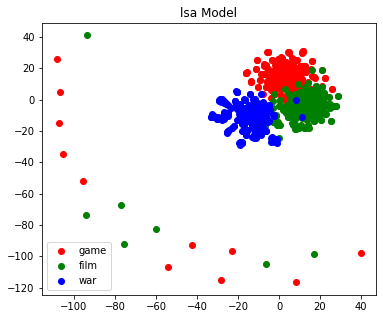

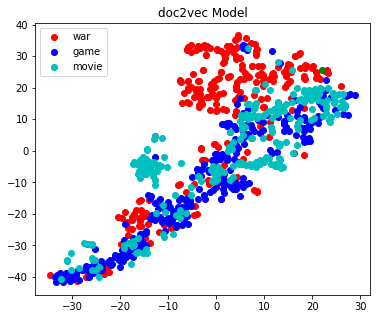

In [38]:
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt


def visualize(model):
  """
  Visualizes a vectorial model using t-SNE
  """

  # PATH_TO_MODEL_DATA = "lsa.dat"

  # Load the data (document vectors each labeled for the document's topic)
  data = np.load(open(model, 'rb'), allow_pickle=True)
  X = np.float32([document_vector for document_topic, document_vector in data])
  all_topics = {document_topic for document_topic, document_vector in data}
  topic2id = {topic_name: topic_id for topic_id, topic_name in enumerate(all_topics)}
  y = np.array([topic2id[document_topic] for document_topic, document_vector in data])


  # Derive the 2D embedding using t-SNE
  tsne = TSNE(n_components=2, random_state=0)
  X_2d = tsne.fit_transform(X)

  # Plot the 2D embedding, with per-topic coloring
  plt.figure(figsize=(6, 5))
  colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
  for topic_id, color, topic in zip(range(len(all_topics)), colors, all_topics):
    plt.scatter(X_2d[y==topic_id, 0], X_2d[y==topic_id, 1], c=color, label=topic)
  plt.title(model[:-4] + " Model")
  plt.legend()
  plt.show()

def main():
  visualize("lsa.dat")
  visualize("doc2vec.dat")

if __name__ == '__main__':
    main()

It looks as though the LSA model is better at delineating between the topics of different articles within the corpus, as the clusters are more defined. There are some extraneous embeddings on the outside of these clusters, which may be due to the erroneous extraction of some Wikipedia articles that were not related to the topics listed. The doc2vec model has topics that are a little less defined, where games and movies are almost interchangeable. This is somewhat predictable with this corpus, due to the many adaptations of games to movies and vice versa. In addition, many games and movies shared the same the same themes, such as action, adventure, or comedy. You may see better results with your corpus, given the topics chose are more separated.

## Conclusion

Overall, these topics are particularly revealing of the effectiveness of the state of the art models created for both distributional and vectoral semantics. Better results may be derived from more separated topics on Wikipedia, or from a different source for the corpora altogether, but I leave that task to you. Thank you for reading this notebook and trying these experiments! ❤️